In [1]:
# https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline  

In [2]:
use_cuda = False
batch_size = 32
latent_size = 20 # z dim

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

In [3]:
def to_var(x):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    bs = recon_x.size(0)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + KLD) / bs

In [4]:
class VAE(nn.Module):
    def __init__(self, feature_size, latent_size):
        super(VAE, self).__init__()
        self.feature_size = feature_size

        # encode
        self.fc1  = nn.Linear(feature_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x): # Q(z|x)
        '''
        x: (bs, feature_size)
        '''
        h1 = self.relu(self.fc1(x))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu

    def decode(self, z): # P(x|z)
        '''
        z: (bs, latent_size)
        '''
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data)
        recon_batch, mu, logvar = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(test_loader):
        data = to_var(data)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [6]:
model = VAE(28*28, latent_size)
if use_cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
for epoch in range(1, 10):
    train(epoch)

/home/ghzuo/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/60000 (0%)]	Loss: 17.148108
Train Epoch: 1 [16000/60000 (27%)]	Loss: 4.612436
Train Epoch: 1 [32000/60000 (53%)]	Loss: 3.768096
Train Epoch: 1 [48000/60000 (80%)]	Loss: 3.832630
Train Epoch: 2 [0/60000 (0%)]	Loss: 3.834043
Train Epoch: 2 [16000/60000 (27%)]	Loss: 3.624880
Train Epoch: 2 [32000/60000 (53%)]	Loss: 3.798143
Train Epoch: 2 [48000/60000 (80%)]	Loss: 3.481422
Train Epoch: 3 [0/60000 (0%)]	Loss: 3.332094
Train Epoch: 3 [16000/60000 (27%)]	Loss: 3.471035
Train Epoch: 3 [32000/60000 (53%)]	Loss: 3.511838
Train Epoch: 3 [48000/60000 (80%)]	Loss: 3.675679
Train Epoch: 4 [0/60000 (0%)]	Loss: 3.502817
Train Epoch: 4 [16000/60000 (27%)]	Loss: 3.289959
Train Epoch: 4 [32000/60000 (53%)]	Loss: 3.433290
Train Epoch: 4 [48000/60000 (80%)]	Loss: 3.177462
Train Epoch: 5 [0/60000 (0%)]	Loss: 3.261912
Train Epoch: 5 [16000/60000 (27%)]	Loss: 3.177394
Train Epoch: 5 [32000/60000 (53%)]	Loss: 3.412372
Train Epoch: 5 [48000/60000 (80%)]	Loss: 2.983952
Train Epoch: 6 [0/60000 

Transition labels: tensor(0) --> tensor(5)


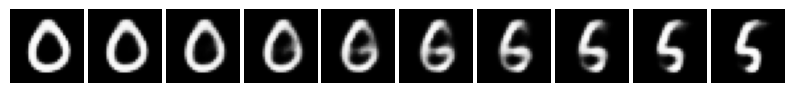

In [8]:
# Let's see a transition from labels[0] to labels[1]
model.eval()
for i, (data, labels) in enumerate(test_loader):
    data = to_var(data)
    mu, logvar = model.encode(data.view(-1, 28*28))
#     print(mu.size(), mu[:3], logvar[:3])
    z = model.reparametrize(mu, logvar)
    print('Transition labels:', labels[0], '-->', labels[1])
    z_cont = to_var(torch.zeros(10, latent_size))
    for i in range(10):
        t = 1.0 - i/9
        z_cont[i] = t * z[0] + (1-t) * z[1]
    samples = model.decode(z_cont).data.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    break

/home/ghzuo/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ghzuo/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ghzuo/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)


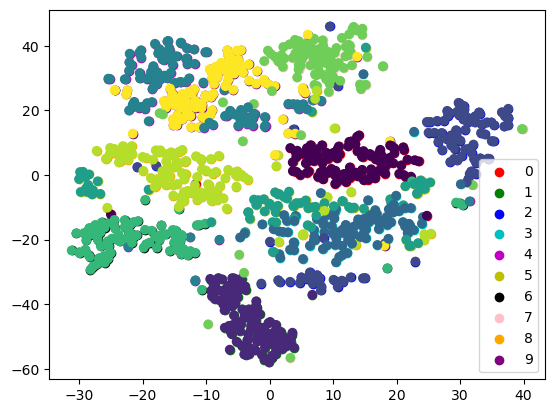

In [9]:
from sklearn.manifold import TSNE

model.eval()
z_list = None
l_list = []
for i, (data, labels) in enumerate(test_loader):
    data = to_var(data)
    mu, logvar = model.encode(data.view(-1, 28*28))
    z = model.reparametrize(mu, logvar)
    if i == 0:
        z_list = z
        l_list = labels
    else:
        z_list = torch.cat((z_list, z), 0)
        l_list = torch.cat((l_list, labels), 0)

z_list = z_list.data.cpu().numpy()[:1000]
l_list = l_list.cpu().numpy()[:1000] # labels are not Variable

X_reduced = TSNE(n_components=2, random_state=0).fit_transform(z_list)

print (X_reduced.shape)
# (N, 2)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
for i, c in enumerate(colors):
    plt.scatter(X_reduced[l_list == i, 0], X_reduced[l_list == i, 1], c=c, label=str(i))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=l_list)
plt.legend()